In [17]:
import librosa
import numpy as np
import librosa.display
import scipy
from scipy.signal import convolve
from scipy.fft import fft, rfft, irfft, rfftfreq

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = 'Стрельба на улице.wav'

SR = 22050

# значения параметров: окна и сдвига
WINDOW_MS = 6
STEP_MS = 1
WINDOW = WINDOW_MS * SR // 1000 
STEP = STEP_MS * SR // 1000

### Задача
Необходимо построить пороговый классификатор на основе энергии спектра для детектирования выстрела в аудиофайле в условиях различных шумов.

Следует отметить, что `выстрел` — это громкий звук с продолжительностью около секунды, постепенно затухающий.

In [3]:
audio, sr = librosa.load(PATH)
ipd.Audio(audio, rate=sr)

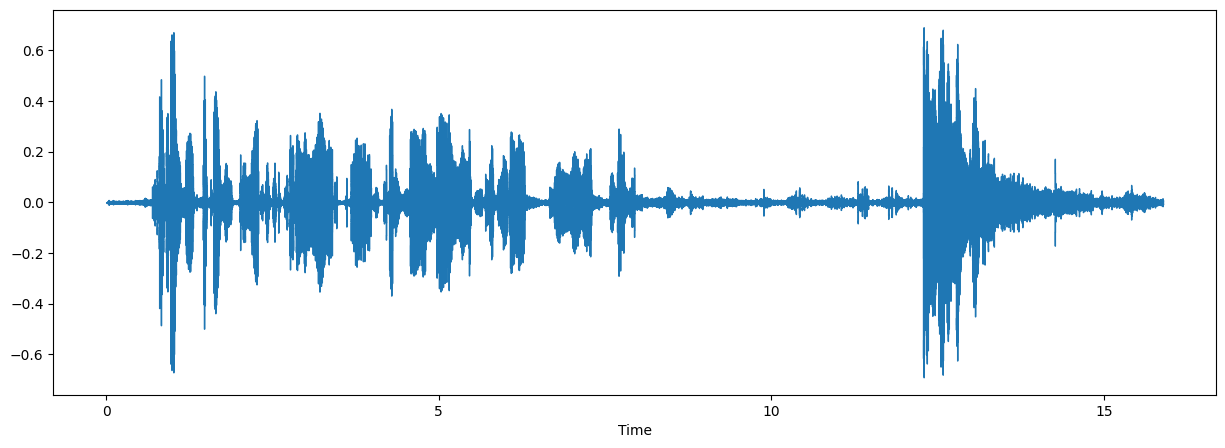

In [4]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio)

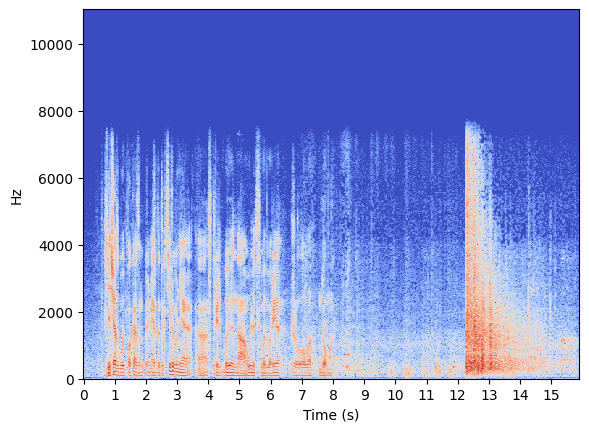

In [5]:
stft = librosa.stft(audio)
stft = librosa.amplitude_to_db(np.abs(stft))
librosa.display.specshow(stft, sr=sr, x_axis='s', y_axis='hz')
plt.xticks(np.arange(0, 16, 1));

После построения `спектрограммы` виден характерный паттерн, соответсвующий выстрелу на промежутке от ~ 12 до 13 сек.

Для наглядности можно построить 3D спектрограмму:

In [6]:
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls


# data = [go.Surface(z=stft.T)]
# layout = go.Layout(
#     title='Spectrogram 3d',
# )

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig);

![image](./resources/3dspec.png)

![image](./resources/3dspec1.png)

### Пайплайн решения:
- Разбить сигнал на окна
- Вычислить амплитудный Фурье-спектр
- Вычислить суммарную энергию
- Савнить результат с порогом
- Использовать фильтрацию шума

In [18]:
def classify(wav, treshold, win, step):
    """Пороговая классификация"""
    
    steps = len(wav) // step + 1
    detected = np.zeros(steps)
    
    for i in range(steps):
        k = i * step
        energy = np.sum(np.abs(fft(wav[k: k + win]) ** 2))
        if energy > treshold:
            detected[i] = 1
    
    ids = np.argwhere(detected == 1)
    first, last = ids[0].item(), ids[-1].item()
    
    detected[first: last] = 1
    res = np.repeat(detected, step)
    
    
    return res[:len(wav)]


def ffilter(signal, treshold_freq):
    """Реализация ФНЧ"""
    spectr = rfft(signal)
    freqs = rfftfreq(len(signal), 1 / SR)
    low_freq = irfft(np.where(freqs > treshold_freq, 0, spectr))
    return low_freq


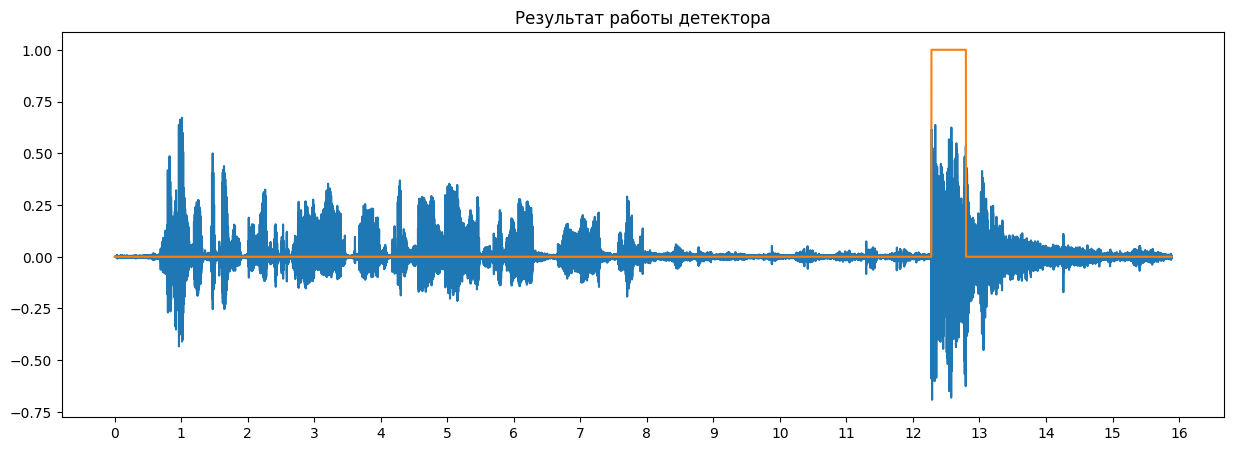

In [8]:
res = classify(audio, 1000, win=WINDOW, step=STEP)
x = [i / SR for i in range(audio.shape[0])]

plt.figure(figsize=(15, 5))
plt.plot(x, audio)
plt.plot(x, res)
plt.xticks(np.arange(0, 17, 1));
plt.title('Результат работы детектора');

In [9]:
times = np.argwhere(res == 1)

In [10]:
start, end = x[times[0].item()], x[times[-1].item()]

In [14]:
print(f"Задетектированное время выстрела {start=:.2f} сек, {end=:.2f} сек")

Задетектированное время выстрела start=12.28 сек, end=12.80 сек


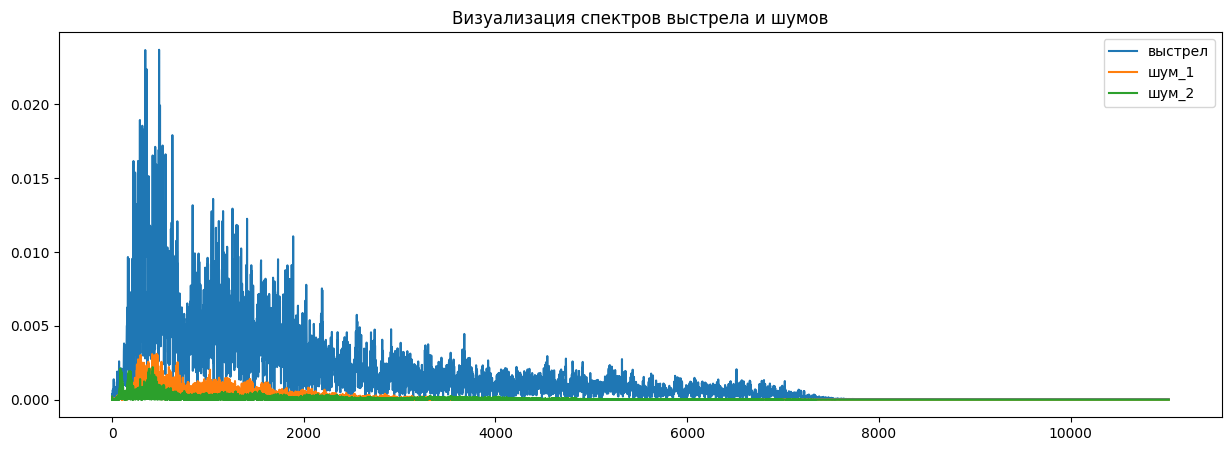

In [15]:
x1 = times[0].item()
x2 = times[-1].item()
plt.figure(figsize=(15, 5))


x = rfftfreq(x2 - x1, 1 / SR)
plt.plot(x, 2 / (x2 - x1) * np.abs(rfft(audio[x1:x2])), label='выстрел')

x = rfftfreq(len(audio) - x2, 1 / SR)
plt.plot(x, 2 / (len(audio) - x2) * np.abs(rfft(audio[x2:])), label='шум_1')

x = rfftfreq(x1, 1 / SR)
plt.plot(x, 2 / x1 * np.abs(rfft(audio[:x1])), label='шум_2')

plt.title('Визуализация спектров выстрела и шумов')
plt.legend();

Подберем порог фильтрации для высокочастотной компоненты спектра

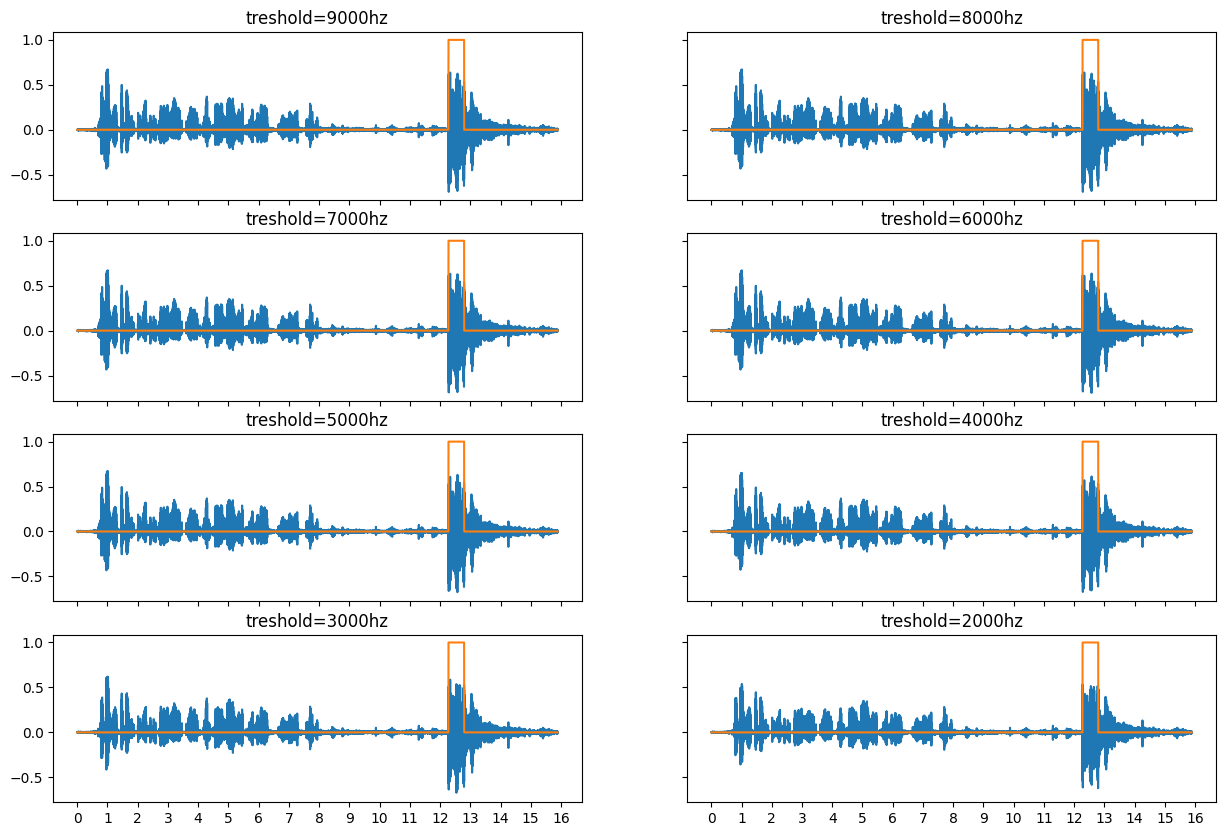

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(15, 10), sharex=True, sharey=True)
ax = ax.ravel()

for i, treshold in enumerate(range(9_000, 1000, -1_000)):
    
    new_audio = ffilter(audio, treshold)
    res = classify(new_audio, 1000, win=WINDOW, step=STEP)
    x = [i / SR for i in range(new_audio.shape[0])]
    
    ax[i].plot(x, new_audio)
    ax[i].plot(x, res)
    ax[i].set_xticks(np.arange(0, 17, 1))
    ax[i].set_title(f'{treshold=}hz')

### Выводы:
- Пороговая классифкация на основе громкости сигнала способна детектировать выстрел в аудиозаписи, в чем можно убедиться также анализируя спектрограмму; однако выбор порога при наличии помех сложная задача, и подобрать единый порог для всех условий невозможно; соотвественно, такое решение нельзя назвать надежным, так как существует риск большого числа ложных срабатываний;
- По результатам анализа спектров было решено построить ФНЧ для удаления шума в аудиозаписи, позволяющего оптимально выполнять детекцию; однако, как и ожидалось, в данном случае фильтр не дал большой производительности в задаче детекции, возможно, стоит увеличить выборку;
- Анализируя спектрограмму, можно заметить характерный паттерн, соотвествующий выстрелу; для повышения помехоустройчивости и надежности полученных результатов можно использовать сверточную нейронную сеть, которая принимает на вход спектрограмму; в таком случае можно настроить фильтрующее ядро, которое находит выстрел в условиях различных изменений масштаба, смещений, и прочих искажений;